### End to end

Process


- Load neccessary data
- Repeat following 10 times
- Randomly select OAs and POIs to form an area of study
- Randomly select a weekday, weekend, bank holiday from period of study
- Cost trips on OTP (and OTP2 / r5?)
- Run matrix spasification techniques
    - knn
    - spatial clustering
    - flow clustering
    - gravity trip generator
- Reduce results as much as possible without loss of information

Module imports

todo: check to see if any unneccsary

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime, timedelta
import random
import numpy as np
from math import radians, cos, sin, asin, sqrt,exp,pow
import math
import statistics
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN

def distance_decay(distance, decay_constant, exponent):
    decay_constant = 1
    exponent = 0.09
    return exp(-decay_constant * pow(distance, exponent))

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the haversine distance between two points given their latitude and longitude.

    Parameters:
    - lat1, lon1: Latitude and longitude of the first point (in degrees)
    - lat2, lon2: Latitude and longitude of the second point (in degrees)

    Returns:
    The haversine distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in kilometers (mean value)
    earth_radius = 6371.0

    # Calculate the haversine distance
    distance = earth_radius * c

    return distance

def flowProx(flow_i,flow_j, alpha=1, beta=1, gamma=1):
    dist = (alpha*((flow_i[0] - flow_j[0]) ** 2) + beta*(((flow_i[2] - flow_j[2]) ** 2) + ((flow_i[3] - flow_j[3]) ** 2))) / ((haversine_distance(flow_i[0],flow_i[1],flow_i[2],flow_i[3]) * haversine_distance(flow_j[0],flow_j[1],flow_j[2],flow_j[3]))**gamma)
    return dist


def getminreach(xi,xj):
    flow_i=tuple([xi[0],xi[1],xi[2],xi[3]])
    flow_j=tuple([xj[0],xj[1],xj[2],xj[3]])
    CDi = xi[4]
    CDj = xj[4]
    prox_dist = flowProx(flow_i,flow_j, alpha=1, beta=1, gamma=1)
    mreachd = max(CDi,CDj,prox_dist)
    return mreachd

/tmp/ipykernel_9961/1032600203.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Set up code paramaters

In [2]:
# Get Time Stamps / Time Interval

stratumDict = {
    'amPeak':{
        'startHour' : 6,
        'startMinute' : 30,
        'endHour' : 9,
        'endMinute' : 00
        },
    'Saturday':{
        'startHour' : 10,
        'startMinute' : 00,
        'endHour' : 18,
        'endMinute' : 00
        },
    'bh':{
        'startHour' : 10,
        'startMinute' : 00,
        'endHour' : 18,
        'endMinute' : 00
        }
    }

#Params
decay_constant = 1
exponent = 0.09

# Vectrise distance decay function
vfunc = np.vectorize(distance_decay)

Import data

Todo:
- Save POI assocations to improve efficiency
- Check OA script all ok?

In [3]:
# Get day index
# Specify the start and end dates
start_date = '2024-03-15'
end_date = '2024-04-15'

# Create a date-time index
date_index = pd.date_range(start=start_date, end=end_date, freq='D')

experiment_dates = pd.DataFrame(index = date_index)

experiment_dates['weekday'] = experiment_dates.index.weekday < 5
experiment_dates['saturday'] = experiment_dates.index.weekday == 5
bank_holidays = ['2024-03-29', '2024-04-01']
experiment_dates['bank_holiday'] = experiment_dates.index.isin(pd.to_datetime(bank_holidays))

# Get OAs
wm_oas = gpd.read_file('data/west_midlands_OAs/west_midlands_OAs.shp')
wm_oas = wm_oas[wm_oas['LAD11CD'] == 'E08000026']
oa_info = pd.read_csv('data/oa_info.csv')
oa_info = oa_info.merge(wm_oas[['OA11CD']], left_on = 'oa_id', right_on = 'OA11CD', how = 'inner')
oaLatLon = oa_info[['oa_id','oa_lon','oa_lat']]

# Get POIs
pois = pd.read_csv('data/POIs/pois_cov.csv', index_col=0)

In [4]:
mean = 50
std_dev = 20
attractivnessDict = {}

for pid in list(pois['poi_id']):
    random_value = random.normalvariate(mean, std_dev)
    attractivnessDict[pid] = max(min(random_value, 100), 0)

Iterate

In [5]:
iteration = 1

For an iteration select random OAs and POI - get from old code don't need to re-invent this

To do - extend this to 200 and 50

In [6]:
#Sample 200 random zones
oaSample = oa_info.sample(30)[['oa_id','oa_lat','oa_lon']]

#POIs
POISample = pois.sample(30)
POISample['attractiveness'] = POISample['poi_id'].map(attractivnessDict)

Define time domain - randomly select trip times and weekend/weekday/bank holiday


Change to more start times

In [7]:
stratum = 'amPeak'

if stratum == 'amPeak':
    study_date = experiment_dates[(experiment_dates['weekday']) & (experiment_dates['bank_holiday'] == False)].sample(1).index

elif stratum == 'Saturday':
    study_date = experiment_dates[(experiment_dates['saturday']) & (experiment_dates['bank_holiday'] == False)].sample(1).index

elif stratum == 'bh':
    study_date = experiment_dates[experiment_dates['bank_holiday']].sample(1).index

# Create Time Domain
startHour = stratumDict[stratum]['startHour']
startMinute = stratumDict[stratum]['startMinute']
endHour = stratumDict[stratum]['endHour']
endMinute = stratumDict[stratum]['endMinute']

start = datetime(year=2012, month=2, day=25, hour=startHour, minute = startMinute)
end = datetime(year=2012, month=2, day=25, hour=endHour, minute = endMinute)
diff = end - start
minutesInInterval = diff.total_seconds()/60
hoursInInterval = minutesInInterval/60

timeDomain = []

for i in range(50):
    randStartTime = start + timedelta(minutes=random.randint(1, int(minutesInInterval)))
    if randStartTime not in timeDomain:
        timeDomain.append(str(randStartTime.hour).zfill(2)+':'+str(randStartTime.minute).zfill(2))

Cost trips using OTP2

In [8]:
import csv
import os, urllib, json, csv, zipfile, math
import time

In [9]:
print('Num Rows : {}'.format(len(oaSample) * len(POISample) * len(timeDomain)))

otp_url = 'http://localhost:8080/otp/routers/default/plan?'
output_file = open('tempdata/tripscosts_otp.csv', 'w')
writer = csv.writer(output_file)
writer.writerow(['trip_id','date','time','oa_id','poi_id','itiniery_id','duration','walk_time','wait_time','transit_time','initial_wait_time','transfers','fare','routing_cost'])

trip_id = 0
itin_id = 0
trip_date = study_date[0].strftime('%m/%d/%Y')

failed_routes_list = []

for oind, orow in oaSample.iterrows():
    for pind,prow in POISample.iterrows():
        for t in timeDomain:
            if trip_id % 500 == 0:
                print(trip_id)
                
            params = {}
            params['date'] = trip_date
            params['time'] = t
            params['fromPlace'] = '%s,%s' % (orow['oa_lat'], orow['oa_lon'])
            params['toPlace'] = '%s,%s' % (prow['poi_lat'], prow['poi_lon'])
            params['mode'] = 'WALK,TRANSIT'
            params['arriveBy'] = 'false'
            params['numItineraries'] = '1'
            params['walkReluctance'] = '20'

            t0 = time.time()
            req = urllib.request.Request(otp_url + urllib.parse.urlencode(params))
            req.add_header('Accept', 'application/json')
            response = urllib.request.urlopen(req)
            content = response.read()
            objs = json.loads(content)
            t1 = time.time()

            if len(objs['plan']['itineraries']) == 0:
                fail_append = {}
                fail_append['oa'] = orow['oa_id']
                fail_append['poi'] = prow['poi_id']
                fail_append['time'] = t
                failed_routes_list.append(fail_append)
                pass
            else:
                i = objs['plan']['itineraries'][0]

            if i['transitTime'] == 0:
                fare = 0
            else:
                fare = (i['transfers'] + 1) * 2.4

            query_time = datetime.strptime(t, '%H:%M').time()
            departure_time = datetime.fromtimestamp(float(i['startTime']) / 1000).time()
            initial_wait_time = (datetime.combine(datetime.today(), departure_time) - datetime.combine(datetime.today(), query_time)).total_seconds()

            row = [trip_id,trip_date,t,orow['oa_id'],prow['poi_id'],itin_id,i['duration'],i['walkTime'],i['waitingTime'],i['transitTime'],initial_wait_time,i['transfers'],fare,(t1-t0)]
            writer.writerow(row)

            trip_id += 1

output_file.close()
failed_routes = pd.DataFrame(failed_routes_list)

Num Rows : 45000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500


In [10]:
trips = pd.read_csv('tempdata/tripscosts_otp.csv')

#Compute generalised access cost
trips['gac'] = (( 1.5 * (trips['duration'])) - (0.5 * trips['transit_time']) + ((trips['fare'] * 3600) / 6.7) + (10 * trips['transfers'])) / 60
trips['att'] = trips['poi_id'].map(attractivnessDict)

In [11]:
#Gravity Model Ground Truth

trips['dist decay'] = vfunc(np.array(trips['gac']),decay_constant, exponent)
trips['grav'] = trips['dist decay'] * trips['att']
gravity = trips.groupby('oa_id').sum()['grav']
print('Gravity model run')

Gravity model run


Get Results KNN

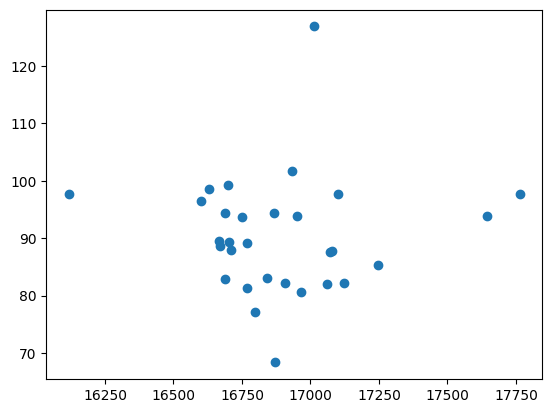

In [13]:
#for k in [5,10,15,20,25]:
k = 20
knn = NearestNeighbors(n_neighbors=k)
knn.fit(POISample[['poi_lon','poi_lat']].values)
kResList = []
countOrigins = 0

for oind, orow in oaSample.iterrows():
    distances, indices = knn.kneighbors(orow[['oa_lon','oa_lat']].values.reshape(1, -1))
    oCosts = []
    oTrips = 0
    oTimes = 0

    for i in indices[0]:
        pid = POISample.iloc[i]['poi_id']
        trips_sample = trips[(trips['oa_id'] == orow['oa_id']) & (trips['poi_id'] == pid)]
        oCosts = oCosts + list(trips_sample['gac'])
        oTrips += len(trips_sample)
        oTimes += trips_sample['routing_cost'].sum()

    kResAppend = {}
    kResAppend['oa_id'] = orow['oa_id']
    kResAppend['knn_ac'] = statistics.mean(oCosts)
    kResList.append(kResAppend)

knnres = pd.DataFrame(kResList).set_index('oa_id')

plt.scatter(gravity,knnres)
plt.show()

Get Results Spatial Clustering

To do : attractiveness weighting

kmeans

[1 1 3 3 3 2 1 3 3 1 4 3 1 4 1 4 0 1 1 4 2 0 2 3 4 4 3 4 4 3]


/tmp/ipykernel_9961/1094574223.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)


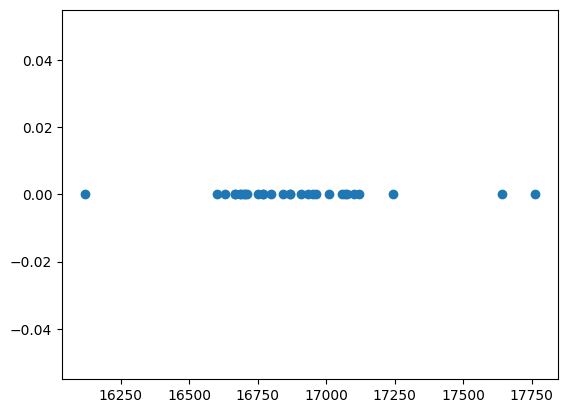

In [15]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(POISample[['poi_lon','poi_lat']].values)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
POISample['cluster'] = cluster_labels
print(cluster_labels)
flows_df = pd.DataFrame(columns = ['oa_id','poi_id','time','gac'])
for cluster in set(cluster_labels):
    if cluster == -1:
        for c_ind in np.where(cluster_labels == cluster)[0]:
            flow_id = POISample.iloc[c_ind]['poi_id']

            for oa in list(oaSample['oa_id']):
                flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)
    else:
        points_in_cluster = np.where(cluster_labels == cluster)[0]
        centroid = [POISample[POISample['cluster'] == cluster]['poi_lon'].mean(),POISample[POISample['cluster'] == cluster]['poi_lat'].mean()]
        distances_to_centroid = np.linalg.norm(POISample[['poi_lon','poi_lat']].values[points_in_cluster] - POISample[['poi_lon','poi_lat']].values[points_in_cluster].mean(axis = 0), axis=1)
        # Find the index of the point closest to the centroid
        closest_point_index = points_in_cluster[np.argmin(distances_to_centroid)]
        flow_id = POISample.iloc[closest_point_index]['poi_id']

        for oa in list(oaSample['oa_id']):
            flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
            for poi in points_in_cluster:
                flow_gac['poi_id'] = poi
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)

flows_df['att'] = flows_df['poi_id'].map(attractivnessDict)

flows_df['dist decay'] = vfunc(np.array(flows_df['gac']),decay_constant, exponent)
flows_df['grav'] = flows_df['dist decay'] * flows_df['att']
kmeans = flows_df.groupby('oa_id').sum()['grav']

plt.scatter(gravity,kmeans)
plt.show()

DBSCAN

Cluster Labels : [-1  0  1  2  1 -1 -1  1  2  3 -1  2  3  4 -1 -1  5  0 -1 -1 -1  5 -1  2
  4 -1 -1 -1  4  2]


/tmp/ipykernel_9961/2292747259.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)


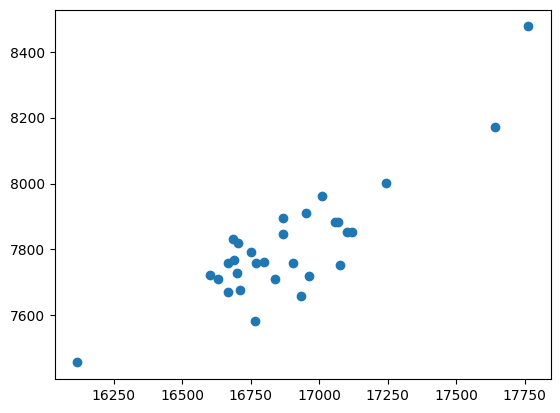

In [16]:
dbscan = DBSCAN(eps=0.01, min_samples=2).fit(POISample[['poi_lon','poi_lat']].values)

# Get cluster labels and centroids
cluster_labels = dbscan.labels_
POISample['cluster'] = cluster_labels

print('Cluster Labels : {}'.format(cluster_labels))

flows_df = pd.DataFrame(columns = ['oa_id','poi_id','time','gac'])

for cluster in set(cluster_labels):
    if cluster == -1:
        for c_ind in np.where(cluster_labels == cluster)[0]:
            flow_id = POISample.iloc[c_ind]['poi_id']

            for oa in list(oaSample['oa_id']):
                flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)
    else:
        points_in_cluster = np.where(cluster_labels == cluster)[0]
        centroid = [POISample[POISample['cluster'] == cluster]['poi_lon'].mean(),POISample[POISample['cluster'] == cluster]['poi_lat'].mean()]
        distances_to_centroid = np.linalg.norm(POISample[['poi_lon','poi_lat']].values[points_in_cluster] - POISample[['poi_lon','poi_lat']].values[points_in_cluster].mean(axis = 0), axis=1)
        # Find the index of the point closest to the centroid
        closest_point_index = points_in_cluster[np.argmin(distances_to_centroid)]
        flow_id = POISample.iloc[closest_point_index]['poi_id']

        for oa in list(oaSample['oa_id']):
            flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
            for poi in points_in_cluster:
                flow_gac['poi_id'] = poi
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)

flows_df['att'] = flows_df['poi_id'].map(attractivnessDict)

flows_df['dist decay'] = vfunc(np.array(flows_df['gac']),decay_constant, exponent)
flows_df['grav'] = flows_df['dist decay'] * flows_df['att']
dbscan = flows_df.groupby('oa_id').sum()['grav']

plt.scatter(gravity,dbscan)
plt.show()

HDBSCAN

Cluster Labels : [ 2  3  6 -1  6  0  1  6  9  2  7  8  2  5  1  7  4  3 -1 -1  0  4  0  9
  5 -1  5 -1  5  8]


/tmp/ipykernel_9961/3395401731.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)


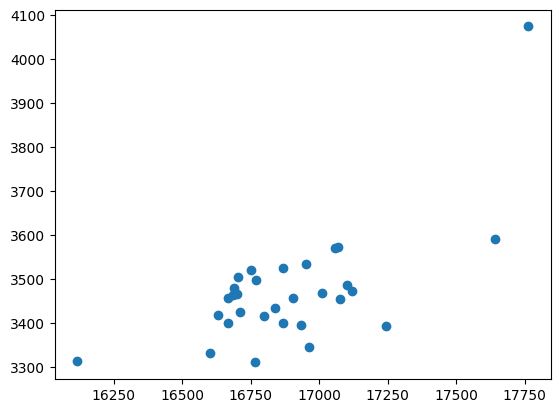

In [17]:
hdbscan = HDBSCAN(min_cluster_size = 2, min_samples=1).fit(POISample[['poi_lon','poi_lat']].values)

# Get cluster labels and centroids
cluster_labels = hdbscan.labels_
POISample['cluster'] = cluster_labels

print('Cluster Labels : {}'.format(cluster_labels))

flows_df = pd.DataFrame(columns = ['oa_id','poi_id','time','gac'])

for cluster in set(cluster_labels):
    if cluster == -1:
        for c_ind in np.where(cluster_labels == cluster)[0]:
            flow_id = POISample.iloc[c_ind]['poi_id']

            for oa in list(oaSample['oa_id']):
                flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)
    else:
        points_in_cluster = np.where(cluster_labels == cluster)[0]
        centroid = [POISample[POISample['cluster'] == cluster]['poi_lon'].mean(),POISample[POISample['cluster'] == cluster]['poi_lat'].mean()]
        distances_to_centroid = np.linalg.norm(POISample[['poi_lon','poi_lat']].values[points_in_cluster] - POISample[['poi_lon','poi_lat']].values[points_in_cluster].mean(axis = 0), axis=1)
        # Find the index of the point closest to the centroid
        closest_point_index = points_in_cluster[np.argmin(distances_to_centroid)]
        flow_id = POISample.iloc[closest_point_index]['poi_id']

        for oa in list(oaSample['oa_id']):
            flow_gac = trips[(trips['oa_id'] == oa) & (trips['poi_id'] == flow_id)][['oa_id','poi_id','time','gac']]
            for poi in points_in_cluster:
                flow_gac['poi_id'] = poi
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)

flows_df['att'] = flows_df['poi_id'].map(attractivnessDict)

flows_df['dist decay'] = vfunc(np.array(flows_df['gac']),decay_constant, exponent)
flows_df['grav'] = flows_df['dist decay'] * flows_df['att']
hdbscan = flows_df.groupby('oa_id').sum()['grav']

plt.scatter(gravity,hdbscan)
plt.show()

Get results flow clusering

In [18]:
flows_index = []
o_index = []
d_index = []
flows = []

oind = 0
for o in oaSample[['oa_lat','oa_lon','oa_id']].values:
    dind = 0
    for d in POISample[['poi_lon','poi_lat','poi_id']].values:
        flows.append(tuple([o[0], o[1], d[0], d[1]]))
        flows_index.append(tuple([o[2],int(d[2])]))
        o_index.append(o[2])
        d_index.append(int(d[2]))
        dind += 1
    oind += 1

# Calculate CoreD

minflows = 3

# Create a NearestNeighbors object with a custom distance function
neighbors_model = NearestNeighbors(n_neighbors=minflows, algorithm='ball_tree', metric=flowProx)
X = np.array(flows)
# Fit the model to your data
neighbors_model.fit(X)

core_distances = []
count = 0
for i in X:
    distances, indices = neighbors_model.kneighbors([i])
    core_distances.append(distances[:, -1][0])

lst_reshaped = np.array(core_distances).reshape((len(core_distances), 1))
X = np.concatenate((X, lst_reshaped), axis=1)

HDBSCAN with flow

In [21]:
# Get flow
# Cluster flows

hdb = HDBSCAN(min_cluster_size=25, min_samples=10, metric=getminreach).fit(X)
cluster_labels = hdb.labels_

print(cluster_labels)


[-1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1
 -1 -1 -1 -1 -1 -1  3  4  7 -1  7  0  1  7  9  3  8 -1  3  6  1  8  5  4
 -1 -1  0  5  0  9  6  2  6 -1  6 -1  3  4 -1 -1 -1  0  1  7 -1  3 -1 -1
  3  6  1 -1  5  4 -1 -1  0  5  0 -1  6  2 -1 -1  6 -1  3  4  7 -1  7  0
  1  7  9  3  8 10  3  6  1  8  5  4 -1 -1  0  5  0  9  6  2  6 -1  6 10
  3  4 -1 -1 -1  0  1  7 -1  3 -1 -1  3  6  1 -1  5  4 -1 -1  0  5  0 -1
  6 -1 -1 -1  6 -1  3  4  7 -1  7  0  1  7  9  3  8 10  3  6  1  8  5  4
 -1 -1  0  5  0  9  6  2  6 -1  6 10  3  4  7 -1  7  0  1  7  9  3  8 10
  3  6  1  8  5  4 -1 -1  0  5  0  9  6  2  6 -1  6 10  3  4  7 -1  7  0
  1  7  9  3  8 10  3  6  1  8  5  4 -1 -1  0  5  0  9  6  2  6 -1  6 10
  3  4  7 -1  7  0  1  7  9  3  8 10  3  6  1  8  5  4 -1 -1  0  5  0  9
  6  2  6 -1  6 10  3  4  7 -1  7  0  1  7  9  3  8 -1  3  6  1  8  5  4
 -1 -1  0  5  0  9  6  2  6 -1  6 -1  3  4  7 -1  7  0  1  7  9  3  8 10
  3  6  1  8  5  4 -1 -1  0  5  0  9  6  2  6 -1  6

/tmp/ipykernel_9961/3849458057.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)


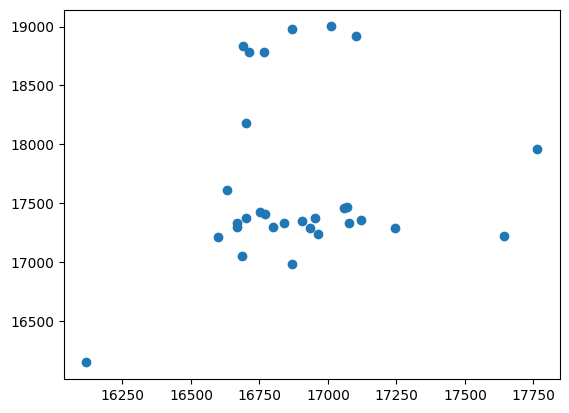

In [22]:

flows_df = pd.DataFrame(columns = ['oa_id','poi_id','time','gac'])
for cluster in set(cluster_labels):
    if cluster == -1:
        cluster_indeces = np.where(cluster_labels==cluster)[0]
        for c_ind in cluster_indeces:
            flow_gac = trips[(trips['oa_id'] == o_index[c_ind]) & (trips['poi_id'] == d_index[c_ind])][['oa_id','poi_id','time','gac']]
            flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)
    else:
        cluster_indeces = np.where(cluster_labels==cluster)[0]
        #Select origin of best flow
        oas_in_flow = list(set([o_index[i] for i in cluster_indeces]))
        distances_to_centroid = np.linalg.norm(oaSample.set_index('oa_id').loc[oas_in_flow].values - oaSample.set_index('oa_id').loc[oas_in_flow].values.mean(axis = 0),axis=1)
        flow_oa = oas_in_flow[np.argmin(distances_to_centroid)]
        #Select destination of best flow
        poi_ids = list(set([d_index[i] for i in cluster_indeces]))
        distances_to_centroid = np.linalg.norm(POISample.set_index('poi_id').loc[poi_ids][['poi_lon','poi_lat']].values - POISample.set_index('poi_id').loc[poi_ids][['poi_lon','poi_lat']].values.mean(axis = 0),axis = 1)
        flow_poi = poi_ids[np.argmin(distances_to_centroid)]
        #measure GAC for all time steps
        flow_gac = trips[(trips['oa_id'] == flow_oa) & (trips['poi_id'] == flow_poi)][['oa_id','poi_id','time','gac']]
        for oa in oas_in_flow:
            for poi in poi_ids:
                flow_gac['oa_id'] = oa
                flow_gac['poi_id'] = poi
                flows_df = pd.concat((flows_df,flow_gac),ignore_index=True)

flows_df['att'] = flows_df['poi_id'].map(attractivnessDict)

flows_df['dist decay'] = vfunc(np.array(flows_df['gac']),decay_constant, exponent)
flows_df['grav'] = flows_df['dist decay'] * flows_df['att']
flowhdbscan = flows_df.groupby('oa_id').sum()['grav']

plt.scatter(gravity,flowhdbscan)
plt.show()

Get Results trip generator